# Adjusted Ratings and all statistics (Percentage based and Fundamentals based)
This colab is designed to be a final product Neural Net, combining the features from two other neural nets with calculated Adjusted Ratings in this colab. 

Additionally, four machine learning algorithms are used:
* Logistic Regression
* Naive Bayes
* Random Forest
* Neural Network

The two features from before our Percentage Based stats (i.e., raw efficiency scores, win percentage, true shooting percentage) and Fundamenal Based stats (assists, rebounds, steals, blocks). 

Those two features sets are combined with what are calculated Adjusted Ratings (pace, offensive efficiency, net efficiency, free throw percentage, etc.). In order to get these adjusted stats, we calculate the ratings for each team for each game of every season, then we make each team and oppoenent a one hot encoder and run a ridge regression for each type of stat. This measures a teams performance across the strength of their opponents. 


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%tensorflow_version 2.x
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split #for train_test_split
import tensorflow as tf #import tensorflow
from tensorflow.keras import layers, optimizers #import tensorflow
from matplotlib import pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
print(tf.__version__)


2.2.0-rc3


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
season_compact = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
season = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv")
teams =  pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MTeams.csv")
season_strings = season['Season'].unique()

teams_df = pd.DataFrame()

for season in season_strings:
  temp_df = pd.DataFrame()
  temp_df['TeamID'] = teams['TeamID']
  temp_df['Season'] = season
  teams_df = pd.concat((teams_df, temp_df))

teams_df['TeamID'] = teams_df['TeamID'].astype(str)
teams_df['Season'] = teams_df['Season'].astype(str)
teams_df

,TeamID,Season
0,1101,2003
1,1102,2003
2,1103,2003
3,1104,2003
4,1105,2003
...,...,...
362,1463,2019
363,1464,2019
364,1465,2019
365,1466,2019


#Feature Selection

Using Ridge Regression, we will be able to calculate adjused ratings based on strength of competition. For each of the following features, we have an adjusted stat and a raw stat (taking the average over a season)

Features:
* Pace
* Offensive, Defensive, and Net Efficiency
* Effective Field Goal Percentage
* Turnover Percentage (percentage of offensive possessions that resulted in a turnover)
* Assist Percentage (percentage of points scored from assists)
* Offensive Rebound Percentage (percent of offensive rebounds per all rebounds available on offense)
* Free Throw Percentage (percent of free throws attempted per all other field goal attempts)

In [6]:
season_compact = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
season = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv")
tourney_results = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv")

#get aggregated stats for games teams won
season_details_winners = season[[ 'WTeamID','Season', 'WScore', 'LScore',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

season_details_winners.columns = [ 'WTeamID','Season', 'Points', 'PointsAllowed',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']

#calculate percentages
season_details_winners = season_details_winners.rename(columns={"WTeamID":"TeamID"}).groupby(['TeamID', 'Season']).sum()
season_details_winners.reset_index(inplace=True)

#get aggregated stats for games teams lost
season_details_losers = season[[ 'LTeamID','Season', 'LScore', 'WScore',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

season_details_losers.columns = ['LTeamID','Season', 'Points', 'PointsAllowed',
       'LFGM', 'LFGA', 'LFGM3', 'LFGA3','LFTM', 'LFTA', 'LOR', 'LDR', 
       'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 
       'WFTM', 'WFTA', 'WOR', 'WDR','WAst', 'WTO', 'WStl', 'WBlk', 'WPF']

#calculate percentages
season_details_losers = season_details_losers.rename(columns={"LTeamID":"TeamID"}).groupby(['TeamID', 'Season']).sum()

season_details_losers.reset_index(inplace=True)

season_details = pd.concat((season_details_winners, season_details_losers))

short_term = season_details.groupby(['TeamID', 'Season']).sum().reset_index().copy()
season_details = season_details.drop(columns=['Season']).groupby(['TeamID']).sum().reset_index()

season_details.columns = ['TeamID', 'Points','PointsAllowed','FGM', 'FGA', 
                          'FGM3', 'FGA3', 'FTM', 'FTA',
       'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'OFGM', 'OFGA',
       'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl',
       'OBlk', 'OPF']

short_term.columns = ['TeamID', 'Season', 'Points','PointsAllowed','FGM', 'FGA', 
                          'FGM3', 'FGA3', 'FTM', 'FTA',
       'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'OFGM', 'OFGA',
       'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl',
       'OBlk', 'OPF']

def long_term_stats(teams): 

  team_stats = ((teams['FGM'] + teams['FGM3']) + (0.4 * teams['FTA']) 
            - (1.07 * (teams['OR'] / (teams['OR'] + teams['ODR']))) 
            * (((teams['FGA'] + teams['FGA3']) - (teams['FGM'] + teams['FGM3'])) + teams['TO']))
  opp_stats = ((teams['OFGM'] + teams['OFGM3']) + (0.4 * teams['OFTA']) 
            - (1.07 * (teams['OOR'] / (teams['OOR'] + teams['DR']))) 
            * (((teams['OFGA'] + teams['OFGA3']) - (teams['OFGM'] + teams['OFGM3'])) + teams['OTO']))
  
  possessions = 0.5 * (team_stats + opp_stats)

  o_possessions = (teams['FGA'] - teams['OR'] 
            + teams['TO'] + (0.475 * teams['FTA']))
  d_possessions = (teams['OFGA'] - teams['OOR'] 
            + teams['OTO'] + (0.475 * teams['OFTA']))

  teams['Raw_Pace'] = 40 * ((possessions * 2) / (2 * (teams['Minutes'] / 5)))
  teams['Raw_OffE'] = 100 * (teams['Points'] / o_possessions)
  teams['Raw_DefE'] = 100 * (teams['PointsAllowed'] / d_possessions)
  teams['Raw_NetE'] = teams['Raw_OffE'] - teams['Raw_DefE']
  teams['Raw_EFG'] = ((1.5 * teams['FGM3']) + teams['FGM']) / (teams['FGA'] + teams['FGA3'])
  teams['Raw_TOPercentage'] = teams['TO'] / o_possessions
  teams['Raw_OffRebPercentage'] = teams['OR'] / (teams['OR'] + teams['ODR'])
  teams['Raw_FTPercentage'] = teams['FTA'] / (teams['FGA'] + teams['FGA3'])



  teams = teams[['TeamID', 'Raw_Pace', 'Raw_OffE', 'Raw_DefE', 
        'Raw_NetE', 'Raw_EFG',  'Raw_TOPercentage', 'Raw_OffRebPercentage',
        'Raw_FTPercentage']]

  return teams

def team_minutes(games):
  wins = games['WTeamID'].value_counts()
  loss = games['LTeamID'].value_counts()
  game_wins = pd.DataFrame({'TeamID' : wins.index, 'Games Played' : wins.values})
  game_loss = pd.DataFrame({'TeamID' : loss.index, 'Games Played' : loss.values})
  game_counts = pd.concat((game_wins, game_loss)).groupby(['TeamID']).sum().reset_index()
  game_counts['Minutes'] = 40 * game_counts['Games Played']
  return game_counts

minutes = team_minutes(season_compact)
season_details = season_details.merge(minutes, on='TeamID', how="left")

stats_long_term = long_term_stats(season_details)

stats_long_term

,TeamID,Raw_Pace,Raw_OffE,Raw_DefE,Raw_NetE,Raw_EFG,Raw_TOPercentage,Raw_OffRebPercentage,Raw_FTPercentage
0,1101,115.290491,99.374982,106.037112,-6.662130,0.466946,0.199125,0.252156,0.259881
1,1102,54.049552,102.472867,102.644015,-0.171148,0.476007,0.195767,0.241540,0.251166
2,1103,50.526991,105.977888,99.175106,6.802782,0.469385,0.190855,0.324604,0.261177
3,1104,44.089752,104.266803,98.866959,5.399844,0.459990,0.198650,0.339114,0.288944
4,1105,72.497104,91.814729,101.428011,-9.613282,0.411535,0.219171,0.312339,0.290649
...,...,...,...,...,...,...,...,...,...
352,1462,52.510827,109.674262,98.206463,11.467799,0.483426,0.191318,0.344319,0.309378
353,1463,51.158011,101.299593,100.376439,0.923154,0.461043,0.211822,0.313527,0.295710
354,1464,53.535371,99.073821,108.052385,-8.978564,0.446969,0.192051,0.300458,0.251363
355,1465,119.876331,107.085841,106.663029,0.422811,0.465769,0.177385,0.287596,0.225011


Now we calculate efficiency scores by each season for each team. 

In [7]:
def season_term_stats(teams): 

  team_stats = ((teams['FGM'] + teams['FGM3']) + (0.4 * teams['FTA']) 
            - (1.07 * (teams['OR'] / (teams['OR'] + teams['ODR']))) 
            * (((teams['FGA'] + teams['FGA3']) - (teams['FGM'] + teams['FGM3'])) + teams['TO']))
  opp_stats = ((teams['OFGM'] + teams['OFGM3']) + (0.4 * teams['OFTA']) 
            - (1.07 * (teams['OOR'] / (teams['OOR'] + teams['DR']))) 
            * (((teams['OFGA'] + teams['OFGA3']) - (teams['OFGM'] + teams['OFGM3'])) + teams['OTO']))
  
  possessions = 0.5 * (team_stats + opp_stats)

  o_possessions = (teams['FGA'] - teams['OR'] 
            + teams['TO'] + (0.475 * teams['FTA']))
  d_possessions = (teams['OFGA'] - teams['OOR'] 
            + teams['OTO'] + (0.475 * teams['OFTA']))

  teams['Raw_Pace'] = 40 * ((possessions * 2) / (2 * (teams['Minutes'] / 5)))
  teams['Raw_OffE'] = 100 * (teams['Points'] / o_possessions)
  teams['Raw_DefE'] = 100 * (teams['PointsAllowed'] / d_possessions)
  teams['Raw_NetE'] = teams['Raw_OffE'] - teams['Raw_DefE']
  teams['Raw_EFG'] = ((1.5 * teams['FGM3']) + teams['FGM']) / (teams['FGA'] + teams['FGA3'])
  teams['Raw_TOPercentage'] = teams['TO'] / o_possessions
  teams['Raw_OffRebPercentage'] = teams['OR'] / (teams['OR'] + teams['ODR'])
  teams['Raw_FTPercentage'] = teams['FTA'] / (teams['FGA'] + teams['FGA3'])



  teams = teams[['TeamID', 'Season', 'Raw_Pace', 'Raw_OffE', 'Raw_DefE', 
        'Raw_NetE', 'Raw_EFG',  'Raw_TOPercentage', 'Raw_OffRebPercentage',
        'Raw_FTPercentage']]

  return teams

def season_team_minutes(games):
  games['count'] = 1
  wins = games.groupby(['Season', 'WTeamID']).sum().reset_index().rename(columns={'WTeamID' : 'TeamID'})
  loss = games.groupby(['Season', 'LTeamID']).sum().reset_index().rename(columns={'LTeamID' : 'TeamID'})
  total = pd.concat((wins, loss))
  total = total[['Season', 'TeamID', 'count']]
  total = total.groupby(['Season', 'TeamID']).sum().reset_index()
  total['Minutes'] = 40 * total['count']
  return total


teams_season_games = season_team_minutes(season_compact[season_compact['Season'] > 2002])
short_term = short_term.merge(teams_season_games, on=['Season','TeamID'], how="left")
stats_short_term = season_term_stats(short_term)

stats_short_term

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,TeamID,Season,Raw_Pace,Raw_OffE,Raw_DefE,Raw_NetE,Raw_EFG,Raw_TOPercentage,Raw_OffRebPercentage,Raw_FTPercentage
0,1101,2014,116.061375,93.950934,116.559003,-22.608069,0.446078,0.223187,0.249258,0.311625
1,1101,2015,105.987069,94.415500,110.422041,-16.006540,0.447994,0.198449,0.241632,0.207528
2,1101,2016,130.091167,100.542428,108.359866,-7.817438,0.468448,0.192982,0.245011,0.298728
3,1101,2017,118.932383,98.297034,105.054595,-6.757561,0.484254,0.209685,0.231902,0.256354
4,1101,2018,112.329475,99.926679,102.573467,-2.646789,0.460998,0.203729,0.265217,0.244186
...,...,...,...,...,...,...,...,...,...,...
5829,1464,2017,125.267414,100.792623,110.583763,-9.791141,0.449716,0.159561,0.263365,0.193674
5830,1464,2018,117.234577,99.124439,113.922476,-14.798037,0.439575,0.193712,0.346444,0.211583
5831,1464,2019,110.662913,103.816003,111.800950,-7.984947,0.449436,0.185503,0.334768,0.160786
5832,1465,2019,119.876331,107.085841,106.663029,0.422811,0.465769,0.177385,0.287596,0.225011


Now we want to get our statistics by each game, the first step is to load each game and create our winners and losers dataframes. 

In [8]:
season = season[[ 'WTeamID','Season', 'LTeamID', 'WScore', 'LScore',
        'WLoc','WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]
season.columns = ['Team', 'Season', 'Opp', 'Points', 'PointsAllowed', 'WLoc','FGM', 'FGA', 
                          'FGM3', 'FGA3', 'FTM', 'FTA',
       'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'OFGM', 'OFGA',
       'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl',
       'OBlk', 'OPF']

season_wins = season.copy()
season_loss = season.copy()

season_loss = season_loss[['Opp', 'Season', 'Team', 'PointsAllowed', 'Points', 'WLoc',
                           'OFGM', 'OFGA','OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 
                           'OAst', 'OTO', 'OStl','OBlk', 'OPF', 'FGM', 'FGA', 
                          'FGM3', 'FGA3', 'FTM', 'FTA','OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF' ]]
season_loss.columns = ['Team', 'Season', 'Opp', 'Points', 'PointsAllowed', 'WLoc','FGM', 'FGA', 
                          'FGM3', 'FGA3', 'FTM', 'FTA',
       'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'OFGM', 'OFGA',
       'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl',
       'OBlk', 'OPF']
season_wins['HCA'] = season_wins['WLoc']
season_wins.loc[season_wins['WLoc'] == 'H', 'HCA'] = 1 
season_wins.loc[season_wins['WLoc'] != 'H', 'HCA'] = 0


season_loss['HCA'] = season_loss['WLoc']
season_loss.loc[season_loss['WLoc'] == 'A', 'HCA'] = 1 
season_loss.loc[season_loss['WLoc'] != 'A', 'HCA'] = 0 


all_games = pd.concat((season_wins, season_loss))
all_games

,Team,Season,Opp,Points,PointsAllowed,WLoc,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OFGM,OFGA,OFGM3,OFGA3,OFTM,OFTA,OOR,ODR,OAst,OTO,OStl,OBlk,OPF,HCA
0,1104,2003,1328,68,62,N,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,0
1,1272,2003,1393,70,63,N,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,0
2,1266,2003,1437,73,61,N,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,0
3,1296,2003,1457,56,50,N,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,0
4,1400,2003,1208,77,71,N,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87499,1222,2019,1153,57,69,N,19,62,8,33,11,18,17,16,8,7,2,4,19,22,50,6,17,19,25,12,27,6,11,2,3,16,0
87500,1426,2019,1209,64,73,N,23,64,7,33,11,17,13,28,12,14,5,2,24,20,50,8,22,25,34,5,31,8,10,4,5,18,0
87501,1276,2019,1277,60,65,N,21,51,8,25,10,12,3,26,17,6,5,5,11,22,55,9,23,12,16,11,27,14,9,2,6,10,0
87502,1382,2019,1387,53,55,N,19,56,7,19,8,10,13,30,9,11,2,7,16,22,59,4,22,7,15,15,25,13,6,6,8,11,0


For each game, we need to calculate the stats for each side of the ball. Since each game has two different perspectives (the loser and the winner), we calculate stats directionally. 

For each game we have two teams, they are loaded in by default as WTeam and LTeam. Our algorithm is going to learn directionality of statistics, so we can load each team as WTeam then LTeam or LTeam then WTeam. The actual values will be the same but the perspective will be different. For rows loaded WTeam then LTeam, we will give the 'Result' a value of 1, and for LTeam then WTeam we give the 'Result' a value of 0. 

In [9]:
def game_stats(games): 

  team_stats = ((games['FGM'] + games['FGM3']) + (0.4 * games['FTA']) 
            - (1.07 * (games['OR'] / (games['OR'] + games['ODR']))) 
            * (((games['FGA'] + games['FGA3']) - (games['FGM'] + games['FGM3'])) + games['TO']))
  opp_stats = ((games['OFGM'] + games['OFGM3']) + (0.4 * games['OFTA']) 
            - (1.07 * (games['OOR'] / (games['OOR'] + games['DR']))) 
            * (((games['OFGA'] + games['OFGA3']) - (games['OFGM'] + games['OFGM3'])) + games['OTO']))
  
  possessions = 0.5 * (team_stats + opp_stats)

  o_possessions = (games['FGA'] - games['OR'] 
            + games['TO'] + (0.475 * games['FTA']))
  d_possessions = (games['OFGA'] - games['OOR'] 
            + games['OTO'] + (0.475 * games['OFTA']))

  games['tm_Pace'] = 40 * ((possessions * 2) / (2 * (40 / 5)))
  games['tm_OffE'] = 100 * (games['Points'] / o_possessions)
  games['tm_DefE'] = 100 * (games['PointsAllowed'] / d_possessions)
  games['tm_NetE'] = games['tm_OffE'] - games['tm_DefE']
  games['tm_EFG'] = ((1.5 * games['FGM3']) + games['FGM']) / (games['FGA'] + games['FGA3'])
  games['tm_TOPercentage'] = games['TO'] / o_possessions
  games['tm_OffRebPercentage'] = games['OR'] / (games['OR'] + games['ODR'])
  games['tm_FTPercentage'] = games['FTA'] / (games['FGA'] + games['FGA3'])

  games['opp_Pace'] = 40 * ((possessions * 2) / (2 * (40 / 5)))
  games['opp_OffE'] = 100 * (games['PointsAllowed'] / o_possessions)
  games['opp_DefE'] = 100 * (games['Points'] / d_possessions)
  games['opp_NetE'] = games['opp_OffE'] - games['opp_DefE']
  games['opp_EFG'] = ((1.5 * games['OFGM3']) + games['OFGM']) / (games['OFGA'] + games['OFGA3'])
  games['opp_TOPercentage'] = games['OTO'] / d_possessions
  games['opp_OffRebPercentage'] = games['OOR'] / (games['OOR'] + games['DR'])
  games['opp_FTPercentage'] = games['OFTA'] / (games['OFGA'] + games['OFGA3'])

  games = games[['Season','Team', 'Opp', 'HCA', 'tm_Pace', 'tm_OffE', 'tm_DefE', 
        'tm_NetE', 'tm_EFG',  'tm_TOPercentage', 'tm_OffRebPercentage',
        'tm_FTPercentage', 'opp_Pace', 'opp_OffE', 'opp_DefE', 
        'opp_NetE', 'opp_EFG',  'opp_TOPercentage', 'opp_OffRebPercentage',
        'opp_FTPercentage']]

  return games

stats_game = game_stats(all_games)
stats_game

,Season,Team,Opp,HCA,tm_Pace,tm_OffE,tm_DefE,tm_NetE,tm_EFG,tm_TOPercentage,tm_OffRebPercentage,tm_FTPercentage,opp_Pace,opp_OffE,opp_DefE,opp_NetE,opp_EFG,opp_TOPercentage,opp_OffRebPercentage,opp_FTPercentage
0,2003,1104,1328,0,62.536356,90.006618,86.773968,3.232650,0.437500,0.304434,0.388889,0.250000,62.536356,82.064858,95.171449,-13.106591,0.396825,0.251924,0.294118,0.349206
1,2003,1272,1393,0,56.444792,101.412532,91.970803,9.441729,0.463415,0.188338,0.375000,0.231707,56.444792,91.271279,102.189781,-10.918502,0.362637,0.175182,0.416667,0.219780
2,2003,1266,1437,0,6.419703,112.697800,93.954563,18.743237,0.473684,0.154381,0.435897,0.381579,6.419703,94.172134,112.437428,-18.265293,0.267677,0.184829,0.543860,0.232323
3,2003,1296,1457,0,51.671474,95.359728,86.021505,9.338222,0.478723,0.204342,0.230769,0.659574,51.671474,85.142614,96.344086,-11.201472,0.380282,0.326882,0.472222,0.211268
4,2003,1400,1208,0,53.911101,119.984418,111.241676,8.742741,0.520000,0.218153,0.531250,0.173333,53.911101,110.634982,120.642382,-10.007399,0.423077,0.156678,0.488372,0.346154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87499,2019,1222,1153,0,45.664367,94.137077,113.347023,-19.209946,0.326316,0.115607,0.386364,0.189474,45.664367,113.955409,93.634497,20.320912,0.462687,0.180698,0.428571,0.373134
87500,2019,1426,1209,0,110.096023,87.581252,102.600141,-15.018888,0.345361,0.191584,0.295455,0.175258,110.096023,99.897366,89.950808,9.946558,0.444444,0.140548,0.151515,0.472222
87501,2019,1276,1277,0,119.287365,100.502513,107.260726,-6.758214,0.434211,0.100503,0.100000,0.157895,119.287365,108.877722,99.009901,9.867821,0.455128,0.148515,0.297297,0.205128
87502,2019,1382,1387,0,45.700439,90.212766,96.280088,-6.067322,0.393333,0.187234,0.342105,0.133333,45.700439,93.617021,92.778993,0.838028,0.345679,0.105033,0.333333,0.185185


In [10]:
stats_game['Team'] = stats_game['Team'].astype(str)
stats_game['Opp'] = stats_game['Opp'].astype(str)
stats_game['Season'] = stats_game['Season'].astype(str)

stats_game

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,Season,Team,Opp,HCA,tm_Pace,tm_OffE,tm_DefE,tm_NetE,tm_EFG,tm_TOPercentage,tm_OffRebPercentage,tm_FTPercentage,opp_Pace,opp_OffE,opp_DefE,opp_NetE,opp_EFG,opp_TOPercentage,opp_OffRebPercentage,opp_FTPercentage
0,2003,1104,1328,0,62.536356,90.006618,86.773968,3.232650,0.437500,0.304434,0.388889,0.250000,62.536356,82.064858,95.171449,-13.106591,0.396825,0.251924,0.294118,0.349206
1,2003,1272,1393,0,56.444792,101.412532,91.970803,9.441729,0.463415,0.188338,0.375000,0.231707,56.444792,91.271279,102.189781,-10.918502,0.362637,0.175182,0.416667,0.219780
2,2003,1266,1437,0,6.419703,112.697800,93.954563,18.743237,0.473684,0.154381,0.435897,0.381579,6.419703,94.172134,112.437428,-18.265293,0.267677,0.184829,0.543860,0.232323
3,2003,1296,1457,0,51.671474,95.359728,86.021505,9.338222,0.478723,0.204342,0.230769,0.659574,51.671474,85.142614,96.344086,-11.201472,0.380282,0.326882,0.472222,0.211268
4,2003,1400,1208,0,53.911101,119.984418,111.241676,8.742741,0.520000,0.218153,0.531250,0.173333,53.911101,110.634982,120.642382,-10.007399,0.423077,0.156678,0.488372,0.346154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87499,2019,1222,1153,0,45.664367,94.137077,113.347023,-19.209946,0.326316,0.115607,0.386364,0.189474,45.664367,113.955409,93.634497,20.320912,0.462687,0.180698,0.428571,0.373134
87500,2019,1426,1209,0,110.096023,87.581252,102.600141,-15.018888,0.345361,0.191584,0.295455,0.175258,110.096023,99.897366,89.950808,9.946558,0.444444,0.140548,0.151515,0.472222
87501,2019,1276,1277,0,119.287365,100.502513,107.260726,-6.758214,0.434211,0.100503,0.100000,0.157895,119.287365,108.877722,99.009901,9.867821,0.455128,0.148515,0.297297,0.205128
87502,2019,1382,1387,0,45.700439,90.212766,96.280088,-6.067322,0.393333,0.187234,0.342105,0.133333,45.700439,93.617021,92.778993,0.838028,0.345679,0.105033,0.333333,0.185185


Now we want to calculate adjusted stats based on the strength of the opponent. First we create a blank dataframe with 0's, we will fill this dataframe in after running our Ridge Regression. 

In [11]:
teams_df['tm_Pace'] = 0.0
teams_df['tm_OffE'] = 0.0
teams_df['tm_DefE'] = 0.0
teams_df['tm_NetE'] = 0.0
teams_df['tm_EFG'] = 0.0
teams_df['tm_TOPercentage'] = 0.0
teams_df['tm_OffRebPercentage'] = 0.0
teams_df['tm_FTPercentage'] = 0.0
teams_df['opp_Pace'] = 0.0
teams_df['opp_OffE'] = 0.0
teams_df['opp_DefE'] = 0.0
teams_df['opp_NetE'] = 0.0
teams_df['opp_EFG'] = 0.0
teams_df['opp_TOPercentage'] = 0.0
teams_df['opp_OffRebPercentage'] = 0.0
teams_df['opp_FTPercentage'] = 0.0
teams_df
melt = teams_df.copy().drop(columns=['TeamID'])
melt

,Season,tm_Pace,tm_OffE,tm_DefE,tm_NetE,tm_EFG,tm_TOPercentage,tm_OffRebPercentage,tm_FTPercentage,opp_Pace,opp_OffE,opp_DefE,opp_NetE,opp_EFG,opp_TOPercentage,opp_OffRebPercentage,opp_FTPercentage
0,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
363,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
364,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
365,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we melt a dataframe to reflect all the stats over all seasons we are going to train on. This dataframe will act as an iterator. 

In [12]:
melt = pd.melt(melt, id_vars=['Season'], value_vars=['tm_Pace', 'tm_OffE', 'tm_DefE', 
        'tm_NetE', 'tm_EFG',  'tm_TOPercentage', 'tm_OffRebPercentage',
        'tm_FTPercentage', 'opp_Pace', 'opp_OffE', 'opp_DefE', 
        'opp_NetE', 'opp_EFG',  'opp_TOPercentage', 'opp_OffRebPercentage',
        'opp_FTPercentage']).drop_duplicates().drop(columns=['value'])
melt

,Season,variable
0,2003,tm_Pace
367,2004,tm_Pace
734,2005,tm_Pace
1101,2006,tm_Pace
1468,2007,tm_Pace
...,...,...
97989,2015,opp_FTPercentage
98356,2016,opp_FTPercentage
98723,2017,opp_FTPercentage
99090,2018,opp_FTPercentage


Now we run our ridge regression. This will iterate through all the rows in our melted dataframe and create a subset dataframe of all games and stats that fit our current iteration. For example, the first iteration will be for all games in 2003, and we will calculate adjusted stats for tm_Pace, or the pace of the first team loaded in the row (either WTeam or LTeam). 


In [13]:
from sklearn import linear_model
stats_game['Season_Team'] = (stats_game['Season'].map(str) + '_' + 
  stats_game['Team'].map(str))

stats_game['Season_Opp'] = (stats_game['Season'].map(str) + '_' + 
  stats_game['Opp'].map(str))

reg = linear_model.Ridge(alpha = 1, fit_intercept = True)

reg_results_collection = pd.DataFrame(columns = ['Season', 'stat_name',
  'coef_name', 'ridge_reg_coef', 'ridge_reg_value'])

for index, row in melt.iterrows():
  this_season_game_stat = stats_game[stats_game['Season'] == str(row['Season'])][['Season_Team', 'HCA', 'Season_Opp', row['variable']]].reset_index()

  this_season_game_dummy_vars = pd.get_dummies(
    this_season_game_stat[['Season_Team', 'HCA', 'Season_Opp']]
    )
  
  # Fit ridge regression to given statistic using season game dummy variables
  reg.fit(
    X = this_season_game_dummy_vars,
    y = this_season_game_stat[row['variable']]
    )
  
  # Extract regression coefficients and put into data fram with coef names
  this_reg_results = pd.DataFrame(
    {
      # Add season and name of stat for this set of results
      'Season': str(row['Season']),
      'stat_name': row['variable'],
      # Coef name, which contains both season and tm_code
      'coef_name': this_season_game_dummy_vars.columns.values,
      # Coef that results from ridge regression
      'ridge_reg_coef': reg.coef_
    }
    )


  # Add intercept back in to reg coef to get 'adjusted' value
  this_reg_results['ridge_reg_value'] = (this_reg_results['ridge_reg_coef'] + 
    reg.intercept_
    )

  reg_results_collection = pd.concat([
    reg_results_collection,
    this_reg_results
    ],
    ignore_index = True
    )
  
reg_results_collection

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Season,stat_name,coef_name,ridge_reg_coef,ridge_reg_value
0,2003,tm_Pace,Season_Team_2003_1102,4.693529,95.551284
1,2003,tm_Pace,Season_Team_2003_1103,19.767548,110.625303
2,2003,tm_Pace,Season_Team_2003_1104,-10.245945,80.611811
3,2003,tm_Pace,Season_Team_2003_1105,2.197478,93.055233
4,2003,tm_Pace,Season_Team_2003_1106,-14.521430,76.336325
...,...,...,...,...,...
187227,2019,opp_FTPercentage,Season_Opp_2019_1462,-0.003298,0.241058
187228,2019,opp_FTPercentage,Season_Opp_2019_1463,-0.004413,0.239943
187229,2019,opp_FTPercentage,Season_Opp_2019_1464,-0.088690,0.155666
187230,2019,opp_FTPercentage,Season_Opp_2019_1465,-0.030884,0.213471


Now that we our ridge regression is finished, we just need to do a little data manipulation in order to load it into our teams_df dataframe. 

In [14]:
adjusted_stats = (reg_results_collection[
  reg_results_collection['coef_name'].str.slice(0, 11) == 'Season_Team'].
  rename(columns = {"ridge_reg_value": "adj_stat"}).
  reset_index(drop = True)
  )


# Extract tm_code and convert back to integer
adjusted_stats['TeamID'] = (adjusted_stats['coef_name'].
  str.slice(-4))

teams_df.set_index(['Season', 'TeamID'], inplace=True)

for index, row in adjusted_stats.iterrows():
  teams_df.at[(row['Season'], row['TeamID']), row['stat_name']] = row['adj_stat']

teams_df.reset_index(inplace=True)
teams_df = teams_df[teams_df['tm_Pace'] != 0]
teams_df

,Season,TeamID,tm_Pace,tm_OffE,tm_DefE,tm_NetE,tm_EFG,tm_TOPercentage,tm_OffRebPercentage,tm_FTPercentage,opp_Pace,opp_OffE,opp_DefE,opp_NetE,opp_EFG,opp_TOPercentage,opp_OffRebPercentage,opp_FTPercentage
1,2003,1102,95.551284,103.773421,101.364328,2.409093,0.512008,0.204252,0.175569,0.283403,95.551284,100.757882,104.190473,-3.432592,0.471556,0.236664,0.363680,0.342621
2,2003,1103,110.625303,108.529233,109.814221,-1.284988,0.486941,0.186259,0.310299,0.350015,110.625303,109.377162,108.881013,0.496149,0.500274,0.214789,0.377971,0.278861
3,2003,1104,80.611811,108.852394,93.128511,15.723883,0.459631,0.193697,0.389299,0.288143,80.611811,92.605263,109.324135,-16.718872,0.417626,0.209932,0.294718,0.244795
4,2003,1105,93.055233,90.214381,108.363890,-18.149508,0.425459,0.235377,0.302830,0.236325,93.055233,107.118615,91.291436,15.827179,0.503385,0.237462,0.378398,0.355925
5,2003,1106,76.336325,90.702453,99.403153,-8.700700,0.440218,0.247548,0.320893,0.218147,76.336325,99.037087,90.989781,8.047306,0.446246,0.222467,0.334817,0.353615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6233,2019,1462,105.732722,110.044260,99.571282,10.472979,0.488653,0.187200,0.327804,0.246030,105.732722,99.287219,110.178481,-10.891262,0.448425,0.173939,0.262984,0.178243
6234,2019,1463,131.448236,110.845811,100.962169,9.883643,0.513901,0.179695,0.258421,0.242081,131.448236,101.619033,110.176742,-8.557709,0.427328,0.148583,0.261656,0.230536
6235,2019,1464,110.265463,102.635534,111.378023,-8.742489,0.451729,0.180275,0.308698,0.158940,110.265463,111.420641,102.615201,8.805440,0.481126,0.166143,0.295347,0.289181
6236,2019,1465,121.529696,105.989539,107.885815,-1.896276,0.460311,0.173898,0.283703,0.215011,121.529696,108.016564,105.777147,2.239417,0.468117,0.151157,0.274287,0.303402


Now we go back and merge our teams_df dataframe with our games. 

In [15]:
#title aggregate wins and losses with stats for each team
season_compact = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
season_compact = season_compact[season_compact['Season'] > 2002]
season_compact = season_compact.drop(columns=[ 'WScore', 'LScore', 'WLoc', 'NumOT'])
season_compact['Season'] = season_compact['Season'].astype(str)

stats_short_term['Season'] = stats_short_term['Season'].astype(str)
stats_short_term['TeamID'] = stats_short_term['TeamID'].astype(str)


season_compact['Season'] = season_compact['Season'].astype(str)
season_compact['WTeamID'] = season_compact['WTeamID'].astype(str)
season_compact['LTeamID'] = season_compact['LTeamID'].astype(str)

season_compact = season_compact.merge(teams_df, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop(columns=['TeamID'])
season_compact = season_compact.merge(teams_df, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop(columns=['TeamID'])
season_compact = season_compact.merge(stats_short_term, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop(columns=['TeamID'])
season_compact = season_compact.merge(stats_short_term, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop(columns=['TeamID'])

wins = pd.DataFrame()
wins['Season'] = season_compact['Season']
wins['WTeamID'] = season_compact['WTeamID']
wins['LTeamID'] = season_compact['LTeamID']
wins['DayNum'] = season_compact['DayNum']

wins['tm_Pace'] = season_compact['tm_Pace_x'] 
wins['tm_OffE'] = season_compact['tm_OffE_x'] 
wins['tm_DefE'] = season_compact['tm_DefE_x'] 
wins['tm_NetE'] = season_compact['tm_NetE_x'] 
wins['tm_EFG'] = season_compact['tm_EFG_x'] 
wins['tm_TOPercentage'] = season_compact['tm_TOPercentage_x'] 
wins['tm_OffRebPercentage'] = season_compact['tm_OffRebPercentage_x'] 
wins['tm_FTPercentage'] = season_compact['tm_FTPercentage_x'] 
wins['Raw_Pace_tm'] = season_compact['Raw_Pace_x']
wins['Raw_OffE_tm'] = season_compact['Raw_OffE_x']
wins['Raw_DefE_tm'] = season_compact['Raw_DefE_x']
wins['Raw_NetE_tm'] =  season_compact['Raw_NetE_x']
wins['Raw_EFG_tm'] =  season_compact['Raw_EFG_x']
wins['Raw_TOPercentage_tm'] =  season_compact['Raw_TOPercentage_x']
wins['Raw_OffRebPercentage_tm'] = season_compact['Raw_OffRebPercentage_x']
wins['Raw_FTPercentage_tm'] = season_compact['Raw_FTPercentage_x']
wins['op_Pace'] = season_compact['tm_Pace_y'] 
wins['op_OffE'] = season_compact['tm_OffE_y'] 
wins['op_DefE'] = season_compact['tm_DefE_y'] 
wins['op_NetE'] = season_compact['tm_NetE_y'] 
wins['op_EFG'] = season_compact['tm_EFG_y'] 
wins['op_TOPercentage'] = season_compact['tm_TOPercentage_y'] 
wins['op_OffRebPercentage'] = season_compact['tm_OffRebPercentage_y'] 
wins['op_FTPercentage'] = season_compact['tm_FTPercentage_y'] 
wins['Raw_Pace_op'] =  season_compact['Raw_Pace_y']
wins['Raw_OffE_op'] = season_compact['Raw_OffE_y']
wins['Raw_DefE_op'] =  season_compact['Raw_DefE_y']
wins['Raw_NetE_op'] =  season_compact['Raw_NetE_y']
wins['Raw_EFG_op'] =  season_compact['Raw_EFG_y']
wins['Raw_TOPercentage_op'] =  season_compact['Raw_TOPercentage_y']
wins['Raw_OffRebPercentage_op'] =  season_compact['Raw_OffRebPercentage_y']
wins['Raw_FTPercentage_op'] =  season_compact['Raw_FTPercentage_y']
wins['Result'] = 1

loss = pd.DataFrame()
loss['Season'] = season_compact['Season']
loss['WTeamID'] = season_compact['WTeamID']
loss['LTeamID'] = season_compact['LTeamID']
loss['DayNum'] = season_compact['DayNum']

loss['tm_Pace'] = season_compact['tm_Pace_y'] 
loss['tm_OffE'] = season_compact['tm_OffE_y'] 
loss['tm_DefE'] = season_compact['tm_DefE_y'] 
loss['tm_NetE'] = season_compact['tm_NetE_y'] 
loss['tm_EFG'] = season_compact['tm_EFG_y'] 
loss['tm_TOPercentage'] = season_compact['tm_TOPercentage_y'] 
loss['tm_OffRebPercentage'] = season_compact['tm_OffRebPercentage_y'] 
loss['tm_FTPercentage'] = season_compact['tm_FTPercentage_y'] 
loss['Raw_Pace_tm'] = season_compact['Raw_Pace_y']
loss['Raw_OffE_tm'] = season_compact['Raw_OffE_y']
loss['Raw_DefE_tm'] = season_compact['Raw_DefE_y']
loss['Raw_NetE_tm'] =  season_compact['Raw_NetE_y']
loss['Raw_EFG_tm'] =  season_compact['Raw_EFG_y']
loss['Raw_TOPercentage_tm'] =  season_compact['Raw_TOPercentage_y']
loss['Raw_OffRebPercentage_tm'] = season_compact['Raw_OffRebPercentage_y']
loss['Raw_FTPercentage_tm'] = season_compact['Raw_FTPercentage_y']
loss['op_Pace'] = season_compact['tm_Pace_x'] 
loss['op_OffE'] = season_compact['tm_OffE_x'] 
loss['op_DefE'] = season_compact['tm_DefE_x'] 
loss['op_NetE'] = season_compact['tm_NetE_x'] 
loss['op_EFG'] = season_compact['tm_EFG_x'] 
loss['op_TOPercentage'] = season_compact['tm_TOPercentage_x'] 
loss['op_OffRebPercentage'] = season_compact['tm_OffRebPercentage_x'] 
loss['op_FTPercentage'] = season_compact['tm_FTPercentage_x'] 
loss['Raw_Pace_op'] =  season_compact['Raw_Pace_x']
loss['Raw_OffE_op'] = season_compact['Raw_OffE_x']
loss['Raw_DefE_op'] =  season_compact['Raw_DefE_x']
loss['Raw_NetE_op'] =  season_compact['Raw_NetE_x']
loss['Raw_EFG_op'] =  season_compact['Raw_EFG_x']
loss['Raw_TOPercentage_op'] =  season_compact['Raw_TOPercentage_x']
loss['Raw_OffRebPercentage_op'] =  season_compact['Raw_OffRebPercentage_x']
loss['Raw_FTPercentage_op'] =  season_compact['Raw_FTPercentage_x']
loss['Result'] = 0

season_pred = pd.concat((wins, loss))
season_pred

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Season,WTeamID,LTeamID,DayNum,tm_Pace,tm_OffE,tm_DefE,tm_NetE,tm_EFG,tm_TOPercentage,tm_OffRebPercentage,tm_FTPercentage,Raw_Pace_tm,Raw_OffE_tm,Raw_DefE_tm,Raw_NetE_tm,Raw_EFG_tm,Raw_TOPercentage_tm,Raw_OffRebPercentage_tm,Raw_FTPercentage_tm,op_Pace,op_OffE,op_DefE,op_NetE,op_EFG,op_TOPercentage,op_OffRebPercentage,op_FTPercentage,Raw_Pace_op,Raw_OffE_op,Raw_DefE_op,Raw_NetE_op,Raw_EFG_op,Raw_TOPercentage_op,Raw_OffRebPercentage_op,Raw_FTPercentage_op,Result
0,2003,1104,1328,10,80.611811,108.852394,93.128511,15.723883,0.459631,0.193697,0.389299,0.288143,78.713863,103.668475,97.587131,6.081343,0.435790,0.198787,0.374753,0.271674,91.664978,113.388058,87.564861,25.823197,0.504071,0.181472,0.361805,0.283174,89.915452,109.428257,91.832971,17.595286,0.483002,0.181441,0.351351,0.246358,1
1,2003,1272,1393,10,90.056920,108.868103,92.258843,16.609261,0.480323,0.192617,0.370666,0.304297,85.686801,105.548501,93.465036,12.083464,0.459302,0.195370,0.373626,0.285960,81.863300,113.842397,94.122236,19.720161,0.497757,0.181276,0.385076,0.311536,80.417675,110.127407,96.740324,13.387084,0.475265,0.187259,0.391140,0.302562,1
2,2003,1266,1437,11,86.457808,117.491935,96.640300,20.851635,0.512729,0.195864,0.428007,0.354099,87.530596,115.406354,100.126810,15.279544,0.501998,0.199792,0.413754,0.330170,89.797994,105.940396,93.246438,12.693958,0.472832,0.213880,0.378518,0.301156,83.100261,101.723571,98.618959,3.104612,0.445629,0.225896,0.390957,0.284861,1
3,2003,1296,1457,11,82.729018,103.092515,100.834329,2.258185,0.485928,0.250547,0.398235,0.328385,87.724849,102.828008,103.445391,-0.617383,0.486305,0.251114,0.392788,0.322191,89.841353,95.791299,102.123411,-6.332112,0.446223,0.224302,0.331960,0.277089,87.341661,100.418410,96.392414,4.025996,0.457223,0.211788,0.335657,0.282375,1
4,2003,1400,1208,11,86.159986,116.100178,92.494209,23.605969,0.487437,0.186696,0.435400,0.336920,85.373328,111.102725,97.476904,13.625820,0.464382,0.189197,0.423761,0.300271,102.721355,118.584248,97.366635,21.217613,0.512001,0.155267,0.371315,0.303586,103.654307,112.384357,103.693014,8.691342,0.487822,0.164003,0.350557,0.273536,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87499,2019,1153,1222,132,98.970947,114.067796,90.716068,23.351728,0.480735,0.161569,0.353905,0.226695,94.281123,111.864075,90.884288,20.979787,0.472768,0.167948,0.347222,0.223027,92.841927,111.508880,93.384375,18.124506,0.469140,0.161736,0.385680,0.293187,88.015609,109.405852,95.651584,13.754268,0.455175,0.160653,0.375862,0.286264,0
87500,2019,1209,1426,132,93.553859,99.767041,98.865011,0.902030,0.434433,0.195847,0.302340,0.247308,95.450548,98.355879,100.039130,-1.683251,0.422347,0.203526,0.310671,0.245159,119.136889,107.556154,101.228596,6.327558,0.498841,0.164826,0.224675,0.255502,118.150551,107.007774,102.409111,4.598663,0.495072,0.166290,0.233212,0.248294,0
87501,2019,1277,1276,132,107.895775,114.514482,84.684807,29.829675,0.496847,0.135623,0.265175,0.218313,106.442522,108.141085,89.436920,18.704165,0.471947,0.135572,0.245004,0.192886,108.839221,121.814929,88.446103,33.368826,0.537527,0.181445,0.357237,0.284148,106.882064,114.726027,94.871085,19.854942,0.510265,0.187072,0.341373,0.253826,0
87502,2019,1387,1382,132,93.074673,101.416885,95.650284,5.766601,0.448315,0.180298,0.288989,0.218267,90.839776,99.777164,95.468049,4.309115,0.444488,0.186694,0.291920,0.211455,91.757625,101.932949,94.967185,6.965764,0.437446,0.184663,0.356119,0.308092,89.379735,100.398901,95.224884,5.174017,0.428922,0.190360,0.361194,0.299020,0


Our training dataframe is all set to go, we just need to scale the inputs and create our training and test set. 

In [16]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))

for stat in ['tm_Pace', 'tm_OffE',
       'tm_DefE', 'tm_NetE', 'tm_EFG', 'tm_TOPercentage',
       'tm_OffRebPercentage', 'tm_FTPercentage', 'Raw_Pace_tm', 'Raw_OffE_tm',
       'Raw_DefE_tm', 'Raw_NetE_tm', 'Raw_EFG_tm', 'Raw_TOPercentage_tm',
       'Raw_OffRebPercentage_tm', 'Raw_FTPercentage_tm', 'op_Pace', 'op_OffE',
       'op_DefE', 'op_NetE', 'op_EFG', 'op_TOPercentage',
       'op_OffRebPercentage', 'op_FTPercentage', 'Raw_Pace_op', 'Raw_OffE_op',
       'Raw_DefE_op', 'Raw_NetE_op', 'Raw_EFG_op', 'Raw_TOPercentage_op',
       'Raw_OffRebPercentage_op', 'Raw_FTPercentage_op']:

  season_pred[stat] = scaler.fit_transform(season_pred[stat].values.reshape(-1,1))


sp = season_pred.copy()
copy = season_pred.copy()

season_preds = season_pred.drop(columns=['Season', 'WTeamID', 'LTeamID', 'DayNum'])
season_preds = season_preds.sample(frac=1)
season_pred = season_preds[0:140000]
season_test = season_preds[140000:]
season_pred

,tm_Pace,tm_OffE,tm_DefE,tm_NetE,tm_EFG,tm_TOPercentage,tm_OffRebPercentage,tm_FTPercentage,Raw_Pace_tm,Raw_OffE_tm,Raw_DefE_tm,Raw_NetE_tm,Raw_EFG_tm,Raw_TOPercentage_tm,Raw_OffRebPercentage_tm,Raw_FTPercentage_tm,op_Pace,op_OffE,op_DefE,op_NetE,op_EFG,op_TOPercentage,op_OffRebPercentage,op_FTPercentage,Raw_Pace_op,Raw_OffE_op,Raw_DefE_op,Raw_NetE_op,Raw_EFG_op,Raw_TOPercentage_op,Raw_OffRebPercentage_op,Raw_FTPercentage_op,Result
18052,-0.152513,-0.015746,0.124981,-0.074125,0.221738,0.185249,0.044052,-0.363478,-0.082807,0.072252,-0.014184,0.032989,0.256693,0.072057,0.024207,-0.231486,-0.208900,-0.335516,0.340356,-0.395296,-0.282913,0.080523,-0.132305,-0.097029,-0.150954,-0.327156,0.287914,-0.405032,-0.332405,0.029501,-0.133642,-0.031487,1
26504,-0.349977,-0.015629,-0.236927,0.112162,-0.097936,-0.131709,0.334353,0.171299,-0.406404,0.140136,-0.562737,0.376171,-0.039244,-0.161988,0.515881,0.141546,-0.510594,-0.298136,0.301558,-0.350744,-0.058984,0.374424,-0.092427,0.178356,-0.578265,-0.211208,-0.091736,-0.120079,0.055646,0.436693,0.086794,0.332491,1
68963,0.181907,0.536261,-0.428535,0.573800,0.600387,-0.522383,-0.078822,0.013392,0.166182,0.426920,-0.323607,0.444194,0.459765,-0.494109,-0.191603,0.023906,-0.002089,0.797302,-0.331961,0.695831,0.689529,-0.604700,0.522593,0.108812,-0.023989,0.682034,-0.226103,0.566980,0.487555,-0.567620,0.490384,0.059740,0
10331,-0.480339,0.103346,-0.115573,0.127987,0.053892,0.090451,0.503992,-0.064330,-0.428944,-0.114578,0.125886,-0.171232,-0.223869,0.105203,0.393500,-0.142614,0.013879,0.184598,0.138313,0.050808,0.335621,-0.075335,-0.041456,-0.118460,0.061786,0.171626,0.200118,-0.014482,0.378351,-0.080407,-0.153760,-0.169679,1
82895,-0.226080,-0.378144,0.078868,-0.288796,0.081000,0.300477,-0.290481,-0.431999,-0.261333,-0.331340,-0.192177,-0.148426,0.138980,0.357524,-0.163125,-0.273588,-0.218667,0.137377,-0.143562,0.164776,0.166072,-0.076201,-0.006487,0.086296,-0.103961,0.121113,-0.197811,0.165848,0.082575,-0.167347,-0.050433,0.154319,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82423,0.276401,0.927351,-0.618408,0.928765,0.836496,-0.671023,0.111035,-0.190556,0.300311,1.000000,-0.622596,1.000000,0.880658,-0.735509,0.022190,-0.108709,-0.191862,0.253016,-0.154765,0.246611,0.150704,-0.209924,0.209885,-0.252340,-0.218854,0.103874,0.001305,0.046370,-0.050520,-0.131462,0.160640,-0.200966,1
42115,-0.242750,0.407606,-0.630262,0.592960,0.298188,-0.279785,0.508651,0.293212,-0.201769,0.260952,-0.465158,0.406537,0.110720,-0.289366,0.457776,0.132867,-0.266013,0.053092,-0.358979,0.220168,-0.115663,-0.149796,0.268214,-0.107893,-0.239811,-0.080344,-0.347467,0.108158,-0.327335,-0.184892,0.214951,-0.306209,0
69020,-0.123397,-0.143543,0.399107,-0.299239,-0.359535,-0.162703,0.214360,0.257452,-0.048576,-0.017257,0.223688,-0.157148,-0.242941,-0.177617,0.299977,0.399465,-0.200467,0.109492,-0.026942,0.086428,-0.141111,-0.441682,0.023510,-0.100943,-0.118934,0.245035,-0.179112,0.240983,0.057485,-0.364154,0.063528,0.015899,0
55996,0.120914,0.219819,0.454425,-0.088671,0.229257,-0.091777,0.212420,0.199795,0.164619,0.378227,0.378260,0.031349,0.332765,-0.219973,0.217538,0.299992,-0.009131,0.251311,0.390587,-0.035108,0.218508,-0.265481,-0.040978,0.006007,-0.029415,0.336279,0.304976,0.042103,0.234848,-0.326490,-0.053778,0.053875,0


This random forest regressor will help us figure out what are the most important features. It's outputs will help focus our Naive Bayes model and it's generally good for understanding the importance of the features in our dataset. 

In [17]:
from sklearn.ensemble import RandomForestRegressor
features = season_pred[['tm_Pace', 'tm_OffE',
       'tm_DefE', 'tm_NetE', 'tm_EFG', 'tm_TOPercentage',
       'tm_OffRebPercentage', 'tm_FTPercentage', 'Raw_Pace_tm', 'Raw_OffE_tm',
       'Raw_DefE_tm', 'Raw_NetE_tm', 'Raw_EFG_tm', 'Raw_TOPercentage_tm',
       'Raw_OffRebPercentage_tm', 'Raw_FTPercentage_tm', 'op_Pace', 'op_OffE',
       'op_DefE', 'op_NetE', 'op_EFG', 'op_TOPercentage',
       'op_OffRebPercentage', 'op_FTPercentage', 'Raw_Pace_op', 'Raw_OffE_op',
       'Raw_DefE_op', 'Raw_NetE_op', 'Raw_EFG_op', 'Raw_TOPercentage_op',
       'Raw_OffRebPercentage_op', 'Raw_FTPercentage_op']]

label = season_pred[['Result']]

test_features = season_test[['tm_Pace', 'tm_OffE',
       'tm_DefE', 'tm_NetE', 'tm_EFG', 'tm_TOPercentage',
       'tm_OffRebPercentage', 'tm_FTPercentage', 'Raw_Pace_tm', 'Raw_OffE_tm',
       'Raw_DefE_tm', 'Raw_NetE_tm', 'Raw_EFG_tm', 'Raw_TOPercentage_tm',
       'Raw_OffRebPercentage_tm', 'Raw_FTPercentage_tm', 'op_Pace', 'op_OffE',
       'op_DefE', 'op_NetE', 'op_EFG', 'op_TOPercentage',
       'op_OffRebPercentage', 'op_FTPercentage', 'Raw_Pace_op', 'Raw_OffE_op',
       'Raw_DefE_op', 'Raw_NetE_op', 'Raw_EFG_op', 'Raw_TOPercentage_op',
       'Raw_OffRebPercentage_op', 'Raw_FTPercentage_op']]

test_label = season_test[['Result']]

rf = RandomForestRegressor()
rf.fit(features, label)
rf.score(test_features, test_label)

fi = pd.DataFrame(rf.feature_importances_, index = features.columns, columns=['importance']).sort_values('importance', ascending=False)

fi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,importance
Raw_NetE_tm,0.148206
Raw_NetE_op,0.141117
op_NetE,0.106847
tm_NetE,0.096702
op_FTPercentage,0.021118
tm_FTPercentage,0.020950
Raw_FTPercentage_tm,0.020711
Raw_FTPercentage_op,0.020679
op_EFG,0.019294
tm_EFG,0.019050


In [0]:
#Create train and test sets for the logistic regression, naive bayes, and random forest
#This creates our train and test sets for our logistic regression, naive bayes, and random forest models. 
all_data = copy.sample(frac=1)
train = all_data[0:140000]
test = all_data[140000:]
parameters = train[['tm_Pace', 'tm_OffE',
       'tm_DefE', 'tm_NetE', 'tm_EFG', 'tm_TOPercentage',
       'tm_OffRebPercentage', 'tm_FTPercentage', 'Raw_Pace_tm', 'Raw_OffE_tm',
       'Raw_DefE_tm', 'Raw_NetE_tm', 'Raw_EFG_tm', 'Raw_TOPercentage_tm',
       'Raw_OffRebPercentage_tm', 'Raw_FTPercentage_tm', 'op_Pace', 'op_OffE',
       'op_DefE', 'op_NetE', 'op_EFG', 'op_TOPercentage',
       'op_OffRebPercentage', 'op_FTPercentage', 'Raw_Pace_op', 'Raw_OffE_op',
       'Raw_DefE_op', 'Raw_NetE_op', 'Raw_EFG_op', 'Raw_TOPercentage_op',
       'Raw_OffRebPercentage_op', 'Raw_FTPercentage_op']].values
labels = train[['Result']].values
test_params = test[['tm_Pace', 'tm_OffE',
       'tm_DefE', 'tm_NetE', 'tm_EFG', 'tm_TOPercentage',
       'tm_OffRebPercentage', 'tm_FTPercentage', 'Raw_Pace_tm', 'Raw_OffE_tm',
       'Raw_DefE_tm', 'Raw_NetE_tm', 'Raw_EFG_tm', 'Raw_TOPercentage_tm',
       'Raw_OffRebPercentage_tm', 'Raw_FTPercentage_tm', 'op_Pace', 'op_OffE',
       'op_DefE', 'op_NetE', 'op_EFG', 'op_TOPercentage',
       'op_OffRebPercentage', 'op_FTPercentage', 'Raw_Pace_op', 'Raw_OffE_op',
       'Raw_DefE_op', 'Raw_NetE_op', 'Raw_EFG_op', 'Raw_TOPercentage_op',
       'Raw_OffRebPercentage_op', 'Raw_FTPercentage_op']].values
test_labels = test[['Result']].values

In [19]:
#Logistic Regression Model
log_reg = LogisticRegression(random_state=0, max_iter=400).fit(parameters, labels)

target_pred = log_reg.predict(test_params)
target_proba = log_reg.predict_proba(test_params)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)

print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.7498571755027422
LogLoss:  0.4946241169612421


In [20]:
lm_probs = pd.DataFrame(target_proba)
lm_probs.describe()

,0,1
count,35008.000000,35008.000000
mean,0.501561,0.498439
std,0.294602,0.294602
min,0.000236,0.000566
25%,0.240124,0.237085
50%,0.502807,0.497193
75%,0.762915,0.759876
max,0.999434,0.999764


##Naive Bayes Model


In [21]:
clf = GaussianNB()
clf.fit(parameters, labels)

target_pred = clf.predict(test_params)
target_proba = clf.predict_proba(test_params)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)
print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

Accuracy:  0.7388025594149908
LogLoss:  0.8667544488763781


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
clf = GaussianNB()

params = train[['Raw_NetE_tm', 'Raw_NetE_op', 'tm_NetE', 'op_NetE', 'tm_FTPercentage']].values
test_pars = test[['Raw_NetE_tm', 'Raw_NetE_op', 'tm_NetE', 'op_NetE', 'tm_FTPercentage']].values
clf.fit(params, labels)
target_pred = clf.predict(test_pars)
target_proba = clf.predict_proba(test_pars)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)
print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

Accuracy:  0.7417161791590493
LogLoss:  0.5155297663303364


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
nb_probs = pd.DataFrame(target_proba)
nb_probs.describe()

,0,1
count,35008.000000,35008.000000
mean,0.501839,0.498161
std,0.307325,0.307325
min,0.000302,0.000476
25%,0.218385,0.213531
50%,0.502243,0.497757
75%,0.786469,0.781615
max,0.999524,0.999698


In [24]:
rf = RandomForestClassifier(max_depth=12, random_state=0)
rf.fit(parameters, labels)

target_pred = rf.predict(test_params)
target_proba = rf.predict_proba(test_params)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)
print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy:  0.7378599177330896
LogLoss:  0.5119297993237006


In [25]:
rf_probs = pd.DataFrame(target_proba)
rf_probs.describe()

,0,1
count,35008.000000,35008.000000
mean,0.501897,0.498103
std,0.281636,0.281636
min,0.002421,0.002212
25%,0.260037,0.256486
50%,0.501802,0.498198
75%,0.743514,0.739963
max,0.997788,0.997579


The Naive Bayes model performed fairly well, after trying it with many different sets of our feature set, it's performance was best when it had all the features. It's LogLoss and Accuracy are on par with the other Naive Bayes models that were run on different sets of features. 

##Let's run a neural network now. 

In [0]:
#title Neural Network
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("binary crossentropy")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  



def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.
  model.add(my_feature_layer)


     
  model.add(tf.keras.layers.Dense(units=32, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  model.add(tf.keras.layers.GaussianDropout(0.15))
  model.add(tf.keras.layers.Dense(units=256, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  model.add(tf.keras.layers.Dense(units=512, 
                                  activation='relu', 
                                  name='Hidden3'))
  model.add(tf.keras.layers.Dropout(0.45))
  model.add(tf.keras.layers.Dense(units=256, 
                                  activation='relu', 
                                  name='Hidden4'))
    
  model.add(tf.keras.layers.GaussianDropout(0.15))
  model.add(tf.keras.layers.Dense(units=128, 
                                  activation='relu', 
                                  name='Hidden5'))
  model.add(tf.keras.layers.Dense(64, 
                                  kernel_regularizer=tf.keras.regularizers.L1L2(0.001, 0.001)))

    
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  activation='relu',
                                  name='Output')) 
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="binary_crossentropy",
                metrics=['accuracy'])

  return model          


def train_model(model, dataset, epochs, label_name,batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=0.2) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["loss"]

  return epochs, mse  

Epoch 1/1200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

45/45 [==============================] - 1s 18ms/step - loss: 1.7512 - accuracy: 0.5330 - val_loss: 1.4669 - val_accuracy: 0.6014
Epoch 2/1200
45/45 [==============================] - 0s 9ms/step - loss: 1.4675 - accuracy: 0.6164 - val_loss: 1.3981 - val_accuracy: 0.6670
Epoch 3/1200
45/45 [==============================] - 0s 9ms/step - loss: 1.4207 - accuracy: 0.6653 - val_loss: 1.3541 - val_accuracy: 0.6961
Epoch 4/1200
45/45 [==============================] - 0s 9ms/step - loss: 1.3952 

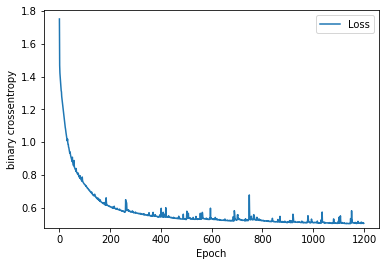


 Evaluate the neural network model against the test set:
15/15 [==============================] - 0s 4ms/step - loss: 0.4962 - accuracy: 0.7473
[0.4961526691913605, 0.747286319732666]


In [27]:
#neural net with adjusted ratings
features = []
for col in season_pred.columns:
  features.append(col)
      
features.pop(-1)
features
feature_columns = feature_columns = [tf.feature_column.numeric_column(key = key) for key in features]

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

learning_rate = 0.0001
epochs = 1200
batch_size = 2500
label_name = 'Result'

# Establish the model's topography.
my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model, season_pred, epochs, label_name, batch_size)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in season_test.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the neural network model against the test set:")
print(my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size))

This will construct the probability distributions for our four models. 

Instructions for updating:
Please use `model.predict()` instead.


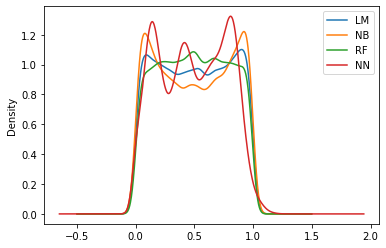

In [28]:
nn_probs = my_model.predict_proba(x = test_features, batch_size=batch_size)
nn_probs = pd.DataFrame(nn_probs)

lm_probs = lm_probs.drop(1, axis=1).rename(columns={0 : 'LM'})
nb_probs = nb_probs.drop(1, axis=1).rename(columns={0 : 'NB'})
rf_probs = rf_probs.drop(1, axis=1).rename(columns={0 : 'RF'})
nn_probs = nn_probs.rename(columns={0 : 'NN'})

probs = pd.DataFrame()
probs['LM'] = lm_probs['LM']
probs['NB'] = nb_probs['NB']
probs['RF'] = rf_probs['RF']
probs['NN'] = nn_probs['NN']


probs.plot.kde()

In [0]:
#@title Save for future implementation



def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("binary crossentropy")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  



def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.
  model.add(my_feature_layer)

  model.add(tf.keras.layers.Dense(units=128, activation='relu'))
  model.add(tf.keras.layers.PReLU())
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.45))
  model.add(tf.keras.layers.GaussianNoise(0.15))
  model.add(tf.keras.layers.Dense(units=256, activation='relu'))
  model.add(tf.keras.layers.PReLU())
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.45))
  model.add(tf.keras.layers.GaussianNoise(0.15))
  model.add(tf.keras.layers.Dense(units=256, activation='relu'))
  model.add(tf.keras.layers.PReLU())
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(0.45))
  model.add(tf.keras.layers.GaussianNoise(0.15))
  model.add(tf.keras.layers.Dense(units=64, kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)))
    
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  activation='relu',
                                  name='Output')) 
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="binary_crossentropy",
                metrics=['accuracy'])

  return model          


def train_model(model, dataset, epochs, label_name,batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=0.2) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["loss"]

  return epochs, mse  

#neural net with adjusted ratings
features = []
for col in season_pred.columns:
  features.append(col)
      
features.pop(-1)
features
feature_columns = feature_columns = [tf.feature_column.numeric_column(key = key) for key in features]

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

learning_rate = 0.0001
epochs = 1500
batch_size = 2500
label_name = 'Result'

# Establish the model's topography.
#my_model = create_model(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
#epochs, mse = train_model(my_model, season_pred, epochs, label_name, batch_size)
#plot_the_loss_curve(epochs, mse)

#test_features = {name:np.array(value) for name, value in season_test.items()}
#test_label = np.array(test_features.pop(label_name)) # isolate the label
#print("\n Evaluate the neural network model against the test set:")
#print(my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size))

Our neural net with adjusted ratings outperformed all of our other models but only by a little. It's logloss and accuracy were a little bit better. The rest of this notebook is an effort to see if combining all of our features (adjusted ratings, fundamentals, and percentages) performs any better. 

In [30]:
fund = pd.read_csv('/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/FundamentalBasedTrain.csv')
fund = fund.drop(columns=['Unnamed: 0'])
fund = fund[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'Ast', 'DR', 'TO', 'FTA', 'Result']]
perc = pd.read_csv('/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/PercentageBasedTrain.csv')
perc = perc.drop(columns=['Unnamed: 0'])
perc = perc[['Season', 'DayNum', 'WTeamID', 'LTeamID', 'WP', 'Net-Efficiency', 'AssistPercentage', 'FTPercentage', 'Result']]
rankings = pd.read_csv('/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/RankingsTrain.csv')
rankings = rankings.drop(columns=['Unnamed: 0'])
sp = sp[['Season', 'DayNum', 'WTeamID', 'LTeamID','Raw_NetE_op', 'Raw_NetE_tm', 'tm_NetE', 'op_NetE', 'Result']]
rankings

,Season,WTeamID,LTeamID,DayNum,POM,SAG,MOR,Result
0,2003,1104,1328,10,0.031329,0.019589,0.048050,1
1,2003,1272,1393,10,0.079288,0.061678,0.021806,1
2,2003,1266,1437,11,-0.099981,-0.118119,-0.050559,1
3,2003,1296,1457,11,-0.241926,-0.179796,-0.216128,1
4,2003,1400,1208,11,-0.020499,-0.031227,-0.008491,1
...,...,...,...,...,...,...,...,...
174903,2019,1153,1222,132,-0.015573,0.002450,-0.013406,0
174904,2019,1209,1426,132,0.257255,0.126173,0.187386,0
174905,2019,1277,1276,132,0.002443,0.009494,0.014625,0
174906,2019,1387,1382,132,0.140917,0.162922,0.096435,0


In [31]:
fund['Season'] = fund['Season'].astype(str)
fund['WTeamID'] = fund['WTeamID'].astype(str)
fund['LTeamID'] = fund['LTeamID'].astype(str)
perc['Season'] = perc['Season'].astype(str)
perc['WTeamID'] = perc['WTeamID'].astype(str)
perc['LTeamID'] = perc['LTeamID'].astype(str)
rankings['Season'] = rankings['Season'].astype(str)
rankings['WTeamID'] = rankings['WTeamID'].astype(str)
rankings['LTeamID'] = rankings['LTeamID'].astype(str)
major = perc.merge(fund, on=['Season', 'WTeamID', 'LTeamID', 'DayNum', 'Result'], how="left")
major = major.merge(sp, on=['Season', 'WTeamID', 'LTeamID', 'DayNum', 'Result'], how="left")
major = rankings.merge(major, on=['Season', 'WTeamID', 'LTeamID', 'DayNum', 'Result'], how="left")

major

,Season,WTeamID,LTeamID,DayNum,POM,SAG,MOR,Result,WP,Net-Efficiency,AssistPercentage,FTPercentage,Ast,DR,TO,FTA,Raw_NetE_op,Raw_NetE_tm,tm_NetE,op_NetE
0,2003,1104,1328,10,0.031329,0.019589,0.048050,1,-2.059639,-1.942623,-1.415669,0.082460,-2.049689,-0.637636,0.887446,1.404199,0.574296,0.255879,0.427506,0.662604
1,2003,1272,1393,10,0.079288,0.061678,0.021806,1,-0.368262,-0.219946,2.692020,-1.631582,2.546584,-1.010886,-0.281385,-0.971129,0.457919,0.421867,0.448117,0.520534
2,2003,1266,1437,11,-0.099981,-0.118119,-0.050559,1,3.432732,2.054144,3.279580,2.355018,2.463768,2.021773,1.255411,2.086614,0.173558,0.510254,0.546873,0.356974
3,2003,1296,1457,11,-0.241926,-0.179796,-0.216128,1,-1.008903,-0.783427,0.497092,0.695646,-0.476190,1.166407,2.316017,-0.209974,0.199039,0.070627,0.114044,-0.085926
4,2003,1400,1208,11,-0.020499,-0.031227,-0.008491,1,0.875841,0.832541,-3.316333,0.027603,-0.020704,1.446345,0.649351,0.104987,0.328059,0.464521,0.610990,0.555392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174903,2019,1153,1222,132,-0.015573,0.002450,-0.013406,0,0.942319,1.219083,-0.471334,-0.106580,1.552795,1.477449,1.580087,-3.280840,0.468073,0.667894,0.605072,0.483389
174904,2019,1209,1426,132,0.257255,0.126173,0.187386,0,-2.336165,-1.059879,3.279658,3.330194,1.987578,1.415241,3.311688,-1.535433,0.214876,0.041151,0.082475,0.208773
174905,2019,1277,1276,132,0.002443,0.009494,0.014625,0,0.000000,-0.194158,-4.614373,-2.142378,-1.904762,-4.339036,-4.220779,-0.603675,0.636786,0.604962,0.755869,0.838255
174906,2019,1387,1382,132,0.140917,0.162922,0.096435,0,-1.364118,-0.145925,-1.338306,5.916581,0.082816,-0.295490,-0.346320,-2.834646,0.230787,0.206869,0.195715,0.223630


Scales all features

In [32]:
for stat in ['POM', 'SAG', 'MOR',
       'WP', 'Net-Efficiency', 'AssistPercentage', 'FTPercentage', 'Ast', 'DR',
       'TO', 'FTA', 'Raw_NetE_op', 'Raw_NetE_tm', 'tm_NetE', 'op_NetE']:

  major[stat] = scaler.fit_transform(major[stat].values.reshape(-1,1))

major = major.drop(columns=['Season', 'WTeamID', 'LTeamID', 'DayNum'])
major = major.sample(frac=1)
major_pred = major[0:140000]
major_test = major[140000:]
major_pred

,POM,SAG,MOR,Result,WP,Net-Efficiency,AssistPercentage,FTPercentage,Ast,DR,TO,FTA,Raw_NetE_op,Raw_NetE_tm,tm_NetE,op_NetE
19720,0.030168,0.136350,0.042647,1,-0.244388,-0.123807,-0.149205,-0.077071,-0.140787,-0.160187,-0.114719,-0.022310,-0.096797,-0.299730,-0.328027,-0.178063
123339,0.451944,0.439614,0.476386,0,-0.087155,-0.063630,0.000775,-0.163027,-0.165631,0.127527,0.138528,0.223097,0.051376,-0.052920,-0.144149,0.257595
68412,0.140850,0.169226,0.131864,1,-0.191630,-0.170136,-0.269841,-0.193574,-0.064182,-0.171073,0.158009,-0.215223,0.324224,0.045353,0.265925,0.391640
2754,0.596596,0.620268,0.607089,1,-0.552531,-0.415619,0.012083,-0.406178,-0.335404,-0.399689,-0.188312,-0.136483,0.416882,-0.264361,-0.212689,0.344343
113702,-0.094690,-0.153758,-0.216225,0,0.244741,0.112062,0.302290,-0.031288,0.260870,0.346812,0.324675,0.124672,0.141784,0.325465,0.427581,0.259882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127392,-0.251453,-0.257314,-0.206277,0,0.207933,0.202470,0.019875,0.271728,0.028986,0.228616,-0.034632,0.069554,-0.286104,0.045765,0.057476,-0.294138
75509,-0.064784,-0.130435,-0.032323,1,0.179089,0.127624,0.425588,-0.194836,0.250518,0.076205,-0.097403,-0.034121,-0.308368,-0.099179,-0.233997,-0.309872
92158,0.120544,0.143850,0.149850,0,-0.097473,-0.042644,0.039088,-0.124512,-0.101449,0.108865,0.140693,0.015748,0.180391,0.110494,0.204915,0.299842
66617,-0.367111,-0.324875,-0.309720,1,0.300866,0.211275,-0.078897,0.131572,0.080745,0.189736,0.025974,-0.005249,-0.248319,0.097983,-0.057016,-0.337003


Finish setting up our training and test sets

In [0]:
parameters = major_pred[['POM', 'SAG', 'MOR',
       'WP', 'Net-Efficiency', 'AssistPercentage', 'FTPercentage', 'Ast', 'DR',
       'TO', 'FTA', 'Raw_NetE_op', 'Raw_NetE_tm', 'tm_NetE', 'op_NetE']].values
labels = major_pred[['Result']].values
test_params = major_test[['POM', 'SAG', 'MOR',
       'WP', 'Net-Efficiency', 'AssistPercentage', 'FTPercentage', 'Ast', 'DR',
       'TO', 'FTA', 'Raw_NetE_op', 'Raw_NetE_tm', 'tm_NetE', 'op_NetE']].values
test_labels = major_test[['Result']].values

In [34]:
#Logistic Regression Model
all_log_reg = LogisticRegression(random_state=0, max_iter=400).fit(parameters, labels)

target_pred = all_log_reg.predict(test_params)
target_proba = all_log_reg.predict_proba(test_params)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)

print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.7617451587028762
LogLoss:  0.48012847722409513


In [35]:
all_lm_probs = pd.DataFrame(target_proba)
all_lm_probs.describe()

,0,1
count,34908.000000,34908.000000
mean,0.500465,0.499535
std,0.303320,0.303320
min,0.001011,0.000686
25%,0.223873,0.221836
50%,0.499940,0.500060
75%,0.778164,0.776127
max,0.999314,0.998989


In [36]:
all_clf = GaussianNB()

all_clf.fit(parameters, labels)
target_pred = all_clf.predict(test_params)
target_proba = all_clf.predict_proba(test_params)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)
print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

Accuracy:  0.7466769794889424
LogLoss:  1.3811044211526866


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
all_nb_probs = pd.DataFrame(target_proba)
all_nb_probs.describe()

,0,1
count,3.490800e+04,3.490800e+04
mean,4.991527e-01,5.008473e-01
std,4.626577e-01,4.626577e-01
min,1.093761e-17,1.305460e-18
25%,5.436672e-04,5.474071e-04
50%,4.856670e-01,5.143330e-01
75%,9.994526e-01,9.994563e-01
max,1.000000e+00,1.000000e+00


In [38]:
all_rf = RandomForestClassifier(max_depth=12, random_state=0)
all_rf.fit(parameters, labels)

target_pred = all_rf.predict(test_params)
target_proba = all_rf.predict_proba(test_params)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)
print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy:  0.7550131774951301
LogLoss:  0.4905431666914247


In [39]:
all_rf_probs = pd.DataFrame(target_proba)
all_rf_probs.describe()

,0,1
count,34908.000000,34908.000000
mean,0.500053,0.499947
std,0.296148,0.296148
min,0.000071,0.000053
25%,0.241418,0.239890
50%,0.499096,0.500904
75%,0.760110,0.758582
max,0.999947,0.999929


In [0]:
#title Neural Network


def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("binary crossentropy")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  



def create_model(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.
  model.add(my_feature_layer)

  model.add(tf.keras.layers.Dense(units=15, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  model.add(tf.keras.layers.GaussianDropout(0.15))
  model.add(tf.keras.layers.Dense(units=256, 
                                  activation='relu', 
                                  name='Hidden2'))
  
  model.add(tf.keras.layers.Dense(units=512, 
                                  activation='relu', 
                                  name='Hidden3'))
  model.add(tf.keras.layers.Dropout(0.45))
  model.add(tf.keras.layers.Dense(units=256, 
                                  activation='relu', 
                                  name='Hidden4'))
    
  model.add(tf.keras.layers.GaussianDropout(0.15))
  model.add(tf.keras.layers.Dense(units=128, 
                                  activation='relu', 
                                  name='Hidden5'))
  model.add(tf.keras.layers.Dense(64, 
                                  kernel_regularizer=tf.keras.regularizers.L1L2(0.001, 0.001)))
  
  model.add(tf.keras.layers.Dense(1,
                                  activation='relu',
                                  name='Output'))
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="binary_crossentropy",
                metrics=['accuracy', 'binary_accuracy'])

  return model          


def train_model(model, dataset, epochs, label_name,batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=0.2) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["loss"]

  return epochs, mse  

Epoch 1/1200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

45/45 [==============================] - 1s 12ms/step - loss: 2.2973 - accuracy: 0.4866 - binary_accuracy: 0.4866 - val_loss: 1.8448 - val_accuracy: 0.4917 - val_binary_accuracy: 0.4917
Epoch 2/1200
45/45 [==============================] - 0s 7ms/step - loss: 1.7224 - accuracy: 0.4839 - binary_accuracy: 0.4839 - val_loss: 1.5595 - val_accuracy: 0.5351 - val_binary_accuracy: 0.5351
Epoch 3/1200
45/45 [==============================] - 0s 7ms/step - loss: 1.4928 - accuracy: 0.5953 - binary_ac

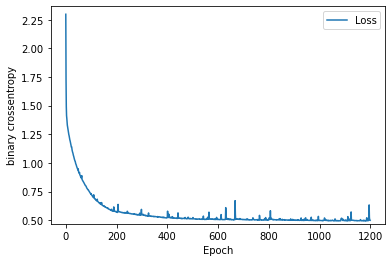


 Evaluate the neural network model against the test set:
14/14 [==============================] - 0s 3ms/step - loss: 0.4943 - accuracy: 0.7597 - binary_accuracy: 0.7597
[0.4942943751811981, 0.7596539258956909, 0.7596539258956909]


In [43]:
features = [ 'POM', 'SAG', 'MOR','WP', 'Net-Efficiency', 'AssistPercentage', 
            'FTPercentage', 'Ast', 'DR','TO', 'FTA', 'Raw_NetE_op', 
            'Raw_NetE_tm', 'tm_NetE', 'op_NetE']
features
feature_columns = [tf.feature_column.numeric_column(key = key) for key in features]
my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
learning_rate = 0.0001
epochs = 1200
batch_size = 2500
label_name = 'Result'

# Establish the model's topography.
my_model_all = create_model(learning_rate, my_feature_layer)
epochs, mse = train_model(my_model_all, major_pred, epochs, label_name, batch_size)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in major_test.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the neural network model against the test set:")
print(my_model_all.evaluate(x = test_features, y = test_label, batch_size=batch_size))

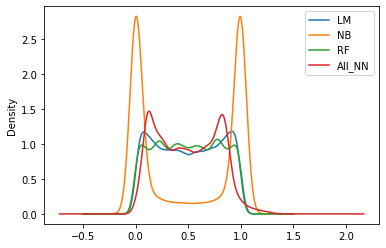

In [44]:
all_nn_probs = my_model_all.predict_proba(x = test_features, batch_size=batch_size)
all_nn_probs = pd.DataFrame(all_nn_probs)

all_lm_probs = all_lm_probs.drop(1, axis=1).rename(columns={0 : 'LM'})
all_nb_probs = all_nb_probs.drop(1, axis=1).rename(columns={0 : 'NB'})
all_rf_probs = all_rf_probs.drop(1, axis=1).rename(columns={0 : 'RF'})
all_nn_probs = all_nn_probs.rename(columns={0 : 'All_NN'})


all_probs = pd.DataFrame()
all_probs['LM'] = all_lm_probs['LM']
all_probs['NB'] = all_nb_probs['NB']
all_probs['RF'] = all_rf_probs['RF']
all_probs['All_NN'] = all_nn_probs['All_NN']

all_probs.plot.kde()